## Welcome to my project!

This project aims at quantifying and demonstarting the difference between parametric modeling (e.g. single-factor Gaussian copula mode) versus non-parametric, universal approximators from unsupervised machine learning, as well as combination of both: Machine Learning (ML) + Montecarlo (MC) simulations. This work is inspired by https://arxiv.org/pdf/2202.11060

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

## The data

In order to provide reproducible, I will rely on the data from Kaggle competition Give Me Some Credit (https://www.kaggle.com/c/GiveMeSomeCredit).

In [2]:
# ===== 6) Load & prepare data (Give Me Some Credit) =====
# Put the CSV at: data/cs-training.csv
df = pd.read_csv("data/GiveMeSomeCredit/cs-training.csv")

# Target and features
y_all = df["SeriousDlqin2yrs"].values.reshape(-1, 1)  # (N,1)
X_all = df.drop(columns=["SeriousDlqin2yrs"])
X_all = X_all.select_dtypes(include=[np.number]).values  # keep numeric only

rng = np.random.default_rng(0)

## The model 

I use a simple neural network activated via ReLu followed by a sigmoid. I also define a forward, entropy loss function and backward propagation (gradient descent).

In [3]:
# ===== 1) Activation functions =====
def relu(Z):
    return np.maximum(0.0, Z)

def sigmoid(Z):
    # numerically stable enough for this use
    return 1.0 / (1.0 + np.exp(-Z))

# ===== 2) He initialization (for ReLU) =====
def he_init(d, H, rng):
    W1 = rng.normal(0.0, np.sqrt(2.0/d), size=(d, H))
    b1 = np.zeros((1, H))
    W2 = rng.normal(0.0, np.sqrt(2.0/H), size=(H, 1))
    b2 = np.zeros((1, 1))
    return W1, b1, W2, b2

# ===== 3) Forward pass =====
def forward(X, W1, b1, W2, b2):
    # X: (N, d)
    Z1 = X @ W1 + b1            # (N, H) affine
    A1 = relu(Z1)               # (N, H) nonlinearity
    Z2 = A1 @ W2 + b2           # (N, 1) logit
    Yhat = sigmoid(Z2)          # (N, 1) probability
    cache = (Z1, A1, Z2, Yhat)  # we need these for backprop
    return Yhat, cache

# ===== 4) Binary cross-entropy loss (mean over batch) =====
def bce_loss(Yhat, y, eps=1e-12):
    Yhat = np.clip(Yhat, eps, 1.0 - eps)
    return -(y * np.log(Yhat) + (1 - y) * np.log(1 - Yhat)).mean()

# ===== 5) Backward pass (gradients via chain rule) =====
def backward(X, y, cache, W2):
    Z1, A1, Z2, Yhat = cache
    N = X.shape[0]
    G2 = (Yhat - y) / N               # (N, 1) output error
    dW2 = A1.T @ G2                   # (H, 1)
    db2 = np.sum(G2, axis=0, keepdims=True)   # (1, 1)
    G1 = (G2 @ W2.T) * (Z1 > 0)       # (N, H) elementwise mask for ReLU
    dW1 = X.T @ G1                    # (d, H)
    db1 = np.sum(G1, axis=0, keepdims=True)   # (1, H)
    return dW1, db1, dW2, db2

## Input

In [4]:
# Impute missing with median, then standardize

imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()

X_all = imputer.fit_transform(X_all)
X_all = scaler.fit_transform(X_all)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

# Define dimensions consistently here (no hard-coding)
d = X_train.shape[1]   # number of features
H = 64                 # hidden units (you can try 32 or 128 later)

## Initialize training

In [12]:
# ===== 8) Training loop (mini-batch SGD) with loss history =====
import matplotlib.pyplot as plt

train_hist, val_hist = [], []  # store loss per epoch

epochs = 500
batch_size = 256
lr = 1e-3

n_train = X_train.shape[0]
for ep in range(1, epochs + 1):
    # shuffle indices for this epoch
    idx = rng.permutation(n_train)

    # iterate over mini-batches by index (no in-place array shuffling)
    for start in range(0, n_train, batch_size):
        stop = min(start + batch_size, n_train)
        bidx = idx[start:stop]
        Xb = X_train[bidx]
        yb = y_train[bidx]

        # forward -> loss
        Yhat_b, cache_b = forward(Xb, W1, b1, W2, b2)
        loss_b = bce_loss(Yhat_b, yb)

        # backward -> grads
        dW1, db1, dW2, db2 = backward(Xb, yb, cache_b, W2)

        # SGD update
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    # end-epoch: evaluate full train/val loss
    train_pred, _ = forward(X_train, W1, b1, W2, b2)
    val_pred, _   = forward(X_val,   W1, b1, W2, b2)
    train_loss = bce_loss(train_pred, y_train)
    val_loss   = bce_loss(val_pred,   y_val)

    # record for plotting
    train_hist.append(train_loss)
    val_hist.append(val_loss)

    # print every 5 epochs (or first)
    if ep % 5 == 0 or ep == 1:
        print(f"epoch {ep:02d} | train={train_loss:.4f} | val={val_loss:.4f}")

epoch 01 | train=0.2108 | val=0.2094
epoch 05 | train=0.2105 | val=0.2090
epoch 10 | train=0.2100 | val=0.2086
epoch 15 | train=0.2096 | val=0.2081
epoch 20 | train=0.2092 | val=0.2077
epoch 25 | train=0.2088 | val=0.2073
epoch 30 | train=0.2084 | val=0.2068
epoch 35 | train=0.2080 | val=0.2064
epoch 40 | train=0.2077 | val=0.2060
epoch 45 | train=0.2073 | val=0.2057
epoch 50 | train=0.2069 | val=0.2053
epoch 55 | train=0.2066 | val=0.2049
epoch 60 | train=0.2063 | val=0.2046
epoch 65 | train=0.2060 | val=0.2042
epoch 70 | train=0.2057 | val=0.2039
epoch 75 | train=0.2053 | val=0.2036
epoch 80 | train=0.2051 | val=0.2033
epoch 85 | train=0.2048 | val=0.2030
epoch 90 | train=0.2045 | val=0.2027
epoch 95 | train=0.2042 | val=0.2024
epoch 100 | train=0.2040 | val=0.2021
epoch 105 | train=0.2037 | val=0.2018
epoch 110 | train=0.2034 | val=0.2016
epoch 115 | train=0.2032 | val=0.2013
epoch 120 | train=0.2030 | val=0.2011
epoch 125 | train=0.2027 | val=0.2009
epoch 130 | train=0.2025 | val=0

## Plotting

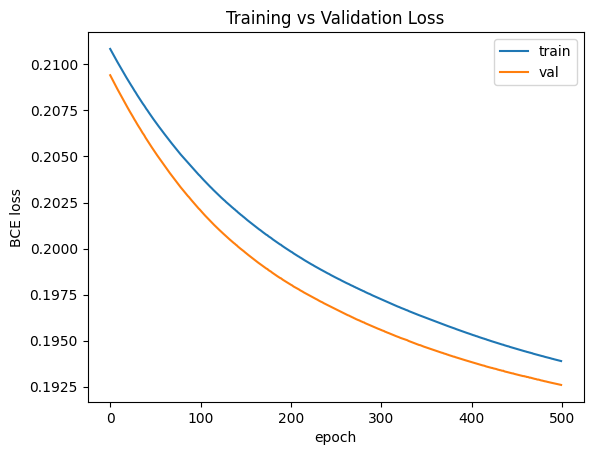

In [13]:
# ===== 9) Plot the loss curves =====
plt.figure()
plt.plot(train_hist, label="train")
plt.plot(val_hist, label="val")
plt.xlabel("epoch")
plt.ylabel("BCE loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


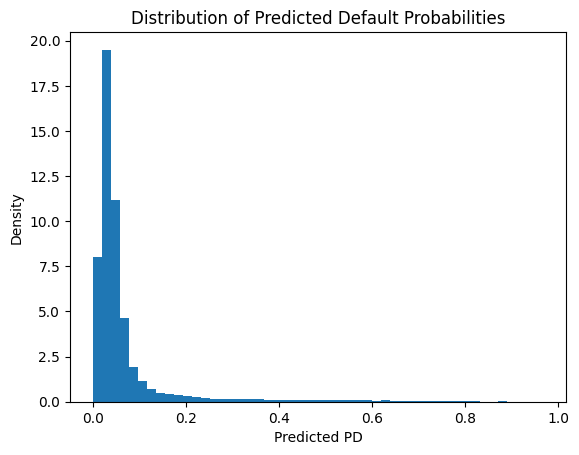

In [14]:
probs_val, _ = forward(X_val, W1, b1, W2, b2)
probs = probs_val.ravel()

plt.figure()
plt.hist(probs, bins=50, density=True)
plt.xlabel("Predicted PD")
plt.ylabel("Density")
plt.title("Distribution of Predicted Default Probabilities")
plt.show()

In [15]:
counts, bins = np.histogram(probs, bins=50, density=True)
area = np.sum(counts * np.diff(bins))
print(area)

0.9999999999999999


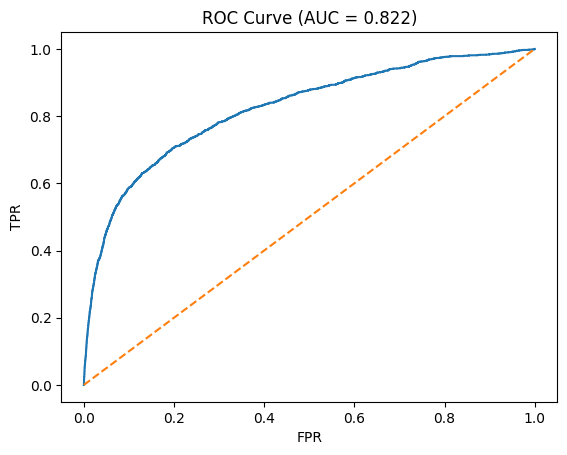

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

y_true = y_val.ravel()
y_score = probs

# ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
auc_roc = roc_auc_score(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC Curve (AUC = {auc_roc:.3f})")
plt.show()


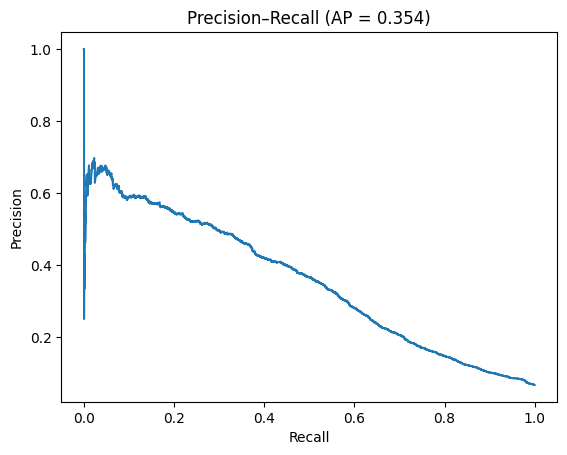

In [18]:
# PR
prec, rec, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.show()

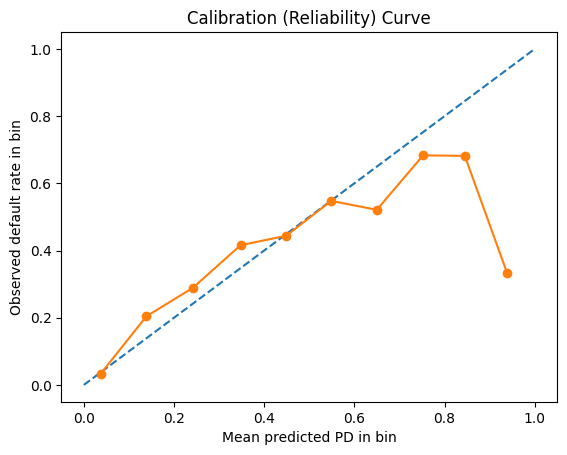

In [19]:
def calib_curve(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    idx = np.digitize(y_prob, bins) - 1
    frac_pos, mean_pred = [], []
    for b in range(n_bins):
        mask = (idx == b)
        if mask.any():
            frac_pos.append(y_true[mask].mean())
            mean_pred.append(y_prob[mask].mean())
    return np.array(mean_pred), np.array(frac_pos)

mp, fp = calib_curve(y_true, y_score, n_bins=10)
plt.figure()
plt.plot([0,1],[0,1],'--')
plt.plot(mp, fp, marker='o')
plt.xlabel("Mean predicted PD in bin")
plt.ylabel("Observed default rate in bin")
plt.title("Calibration (Reliability) Curve")
plt.show()